# Импорт библиотек

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm

# Загрузка датасета

In [50]:
# Преобразование изображения в тензор
trans = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

ds_mnist = tv.datasets.MNIST('./data', download=True, transform=trans)

proportions = [0.6, 0.2, 0.2]
size = len(ds_mnist)

train_ds, valid_ds, test_ds = random_split(ds_mnist, [int(x * size) for x in proportions])

print("Размер тренировочного датасета:", len(train_ds))
print("Размер валидационного датасета:", len(valid_ds))
print("Размер тестового датасета:", len(test_ds))

Размер тренировочного датасета: 36000
Размер валидационного датасета: 12000
Размер тестового датасета: 12000


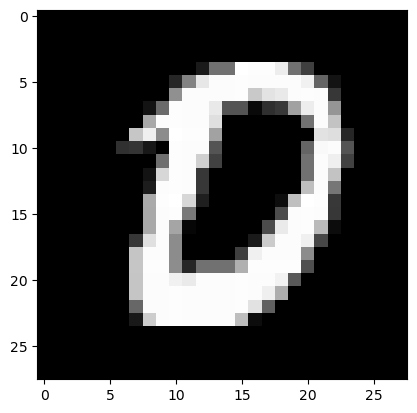

In [51]:
# Обращаемся к двумерному тензору
img = train_ds[9][0].numpy()[0]
plt.imshow(img, cmap='gray')

# Даталоадер

In [52]:
batch_size = 16

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=1, drop_last=True
)

valid_loader =  DataLoader(
    valid_ds, batch_size=batch_size, shuffle=True,
    num_workers=1, drop_last=False
)

test_loader =  DataLoader(
    test_ds, batch_size=batch_size, shuffle=True,
    num_workers=1, drop_last=False
)

# Архитектура нейронной сети

### Полносвязная нейронная сеть

In [53]:
# Fully Connected Neural Network
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(28 * 28, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.flat(x)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        out = self.act(out)
        out = self.linear3(out)

        return out

### Сверточная нейронная сеть

In [54]:
# Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv0 = nn.Conv2d(1, 128, 2, stride=1, padding=0)
        self.conv1 = nn.Conv2d(128, 128, 2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(128, 128, 2, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 28*28, 2, stride=1, padding=0)

        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 20)
        self.linear2 = nn.Linear(20, 10)

    def forward(self, x):


        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)

        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [55]:
model = FCNN()

# Оптимайзер, функция потерь, метрики

In [56]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

def accuracy(pred, label):
    pred_softmax = F.softmax(pred, dim=1)
    pred_argmax = pred_softmax.argmax(1).detach().numpy()
    label_argmax = label.argmax(1).numpy()
    answer = (pred_argmax == label_argmax)
    return answer.mean()

# Обучение

In [57]:
# На чём обучаем
device = torch.device("mps") # mps для Mac с процессорами Apple Slicon (M1, M2)! Альтернативы - 'cuda', 'cpu'
model = model.to(device)
loss_fn = loss_fn.to(device)

In [58]:
epochs = 10

accuracy_train = []
accuracy_valid = []
losses_train = []
losses_valid = []

for epoch in range(epochs):
    print(f"{epoch+1}/{epochs}")

    loss_train = 0
    acc_train = 0
    loss_valid = 0
    acc_valid = 0

    for img, label in (pbar := tqdm(train_loader)):
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)

        label = F.one_hot(label, 10).float()
        pred = model(img)

        loss = loss_fn(pred, label)

        loss.backward()
        loss_item = loss.item()
        loss_train += loss_item

        optimizer.step()

        acc_current = accuracy(pred.cpu(), label.cpu())
        acc_train += acc_current

        #pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')

    accuracy_train.append(acc_train/len(train_loader))
    losses_train.append(loss_train/len(train_loader))
    print(f"train acc: {accuracy_train[-1]}")
    print(f"train loss: {losses_train[-1]}")

    for img,label in (pbar := tqdm(valid_loader)):
        with torch.no_grad():
            img = img.to(device)
            label = label.to(device)
            pred = model(img)
            label = F.one_hot(label, 10).float()
            loss = loss_fn(pred, label)
            loss_item = loss.item()
            loss_valid += loss_item
            acc_current = accuracy(pred.cpu(), label.cpu())
            acc_valid += acc_current

    accuracy_valid.append(acc_valid/len(valid_loader))
    losses_valid.append(loss_valid/len(valid_loader))

    print(f"valid acc: {accuracy_valid[-1]}")
    print(f"valid loss: {losses_valid[-1]}")

1/10


100%|██████████| 2250/2250 [00:11<00:00, 203.36it/s]


train acc: 0.5825
train loss: 1.2802025111052726


100%|██████████| 750/750 [00:02<00:00, 279.05it/s]


valid acc: 0.8368333333333333
valid loss: 0.529954545468092
2/10


100%|██████████| 2250/2250 [00:11<00:00, 197.92it/s]


train acc: 0.8675
train loss: 0.4490200475917922


100%|██████████| 750/750 [00:02<00:00, 264.82it/s]


valid acc: 0.8859166666666667
valid loss: 0.3892907033214966
3/10


100%|██████████| 2250/2250 [00:10<00:00, 222.94it/s]


train acc: 0.8955
train loss: 0.3671149229026503


100%|██████████| 750/750 [00:02<00:00, 284.07it/s]


valid acc: 0.89875
valid loss: 0.3401634899725517
4/10


100%|██████████| 2250/2250 [00:10<00:00, 222.41it/s]


train acc: 0.9067777777777778
train loss: 0.32426927191515764


100%|██████████| 750/750 [00:02<00:00, 290.89it/s]


valid acc: 0.90975
valid loss: 0.3068545709177852
5/10


100%|██████████| 2250/2250 [00:11<00:00, 203.34it/s]


train acc: 0.9151944444444444
train loss: 0.29227984607178303


100%|██████████| 750/750 [00:03<00:00, 237.71it/s]


valid acc: 0.91725
valid loss: 0.28153734747817116
6/10


100%|██████████| 2250/2250 [00:11<00:00, 201.06it/s]


train acc: 0.9225555555555556
train loss: 0.26703965272092156


100%|██████████| 750/750 [00:02<00:00, 254.51it/s]


valid acc: 0.924
valid loss: 0.2682850285843015
7/10


100%|██████████| 2250/2250 [00:10<00:00, 205.00it/s]


train acc: 0.9291944444444444
train loss: 0.247606005123506


100%|██████████| 750/750 [00:02<00:00, 266.67it/s]


valid acc: 0.9260833333333334
valid loss: 0.2526409181902806
8/10


100%|██████████| 2250/2250 [00:11<00:00, 204.23it/s]


train acc: 0.9330277777777778
train loss: 0.23175646942646966


100%|██████████| 750/750 [00:03<00:00, 249.89it/s]


valid acc: 0.9339166666666666
valid loss: 0.23413167861476541
9/10


100%|██████████| 2250/2250 [00:10<00:00, 205.86it/s]


train acc: 0.9369722222222222
train loss: 0.2171923376719157


100%|██████████| 750/750 [00:03<00:00, 249.30it/s]


valid acc: 0.93325
valid loss: 0.22658170735711852
10/10


100%|██████████| 2250/2250 [00:10<00:00, 208.11it/s]


train acc: 0.9405
train loss: 0.20582335229176615


100%|██████████| 750/750 [00:02<00:00, 277.84it/s]

valid acc: 0.9353333333333333
valid loss: 0.21792570959528287


### График обучения

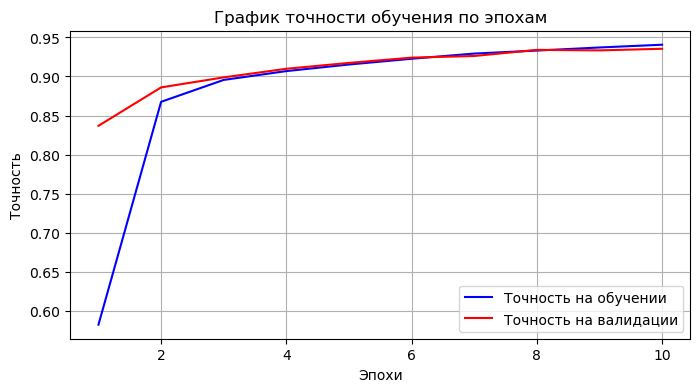

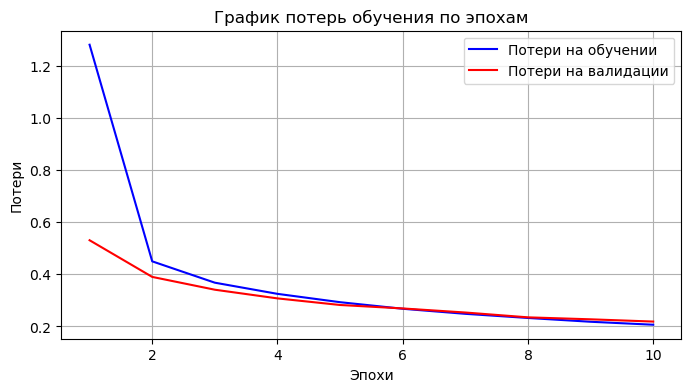

In [59]:
x = range(1, epochs + 1)

# Строим график для точности
plt.figure(figsize=(8, 4))
plt.plot(x, accuracy_train, 'b', label='Точность на обучении')
plt.plot(x, accuracy_valid, 'r', label='Точность на валидации')
plt.title('График точности обучения по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# Строим график для потерь
plt.figure(figsize=(8, 4))
plt.plot(x, losses_train, 'b', label='Потери на обучении')
plt.plot(x, losses_valid, 'r', label='Потери на валидации')
plt.title('График потерь обучения по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

# Отображаем оба графика
plt.show()

### Сохранение модели

In [60]:
save_path = './models/model1.pth'
torch.save(model.state_dict(), save_path)

# Использование модели

### Загрузка модели из файла

In [61]:
model = FCNN()
# модели находятся в папке models, самая точная 'cnn1.pth',
# для использования нужно изменить тип модели на model = CNN()
load_path = './models/model1.pth'
model.load_state_dict(torch.load(load_path))
model.eval();

In [62]:
model = model.to('cpu')  # Опционально

### Тест

In [63]:
loss_test = 0
acc_test = 0

for img,label in (pbar := tqdm(test_loader)):
    with torch.no_grad():
        pred = model(img)
        label = F.one_hot(label, 10).float()
        loss = loss_fn(pred, label)
        loss_item = loss.item()
        loss_test += loss_item
        acc_current = accuracy(pred.cpu(), label.cpu())
        acc_test += acc_current

print(f"Средние потери: {loss_test/len(test_loader)}")
print(f"Средняя точность: {acc_test/len(test_loader)}")

100%|██████████| 750/750 [00:01<00:00, 559.40it/s] 

Средние потери: 0.2096729658320546
Средняя точность: 0.9385


### Пеинт

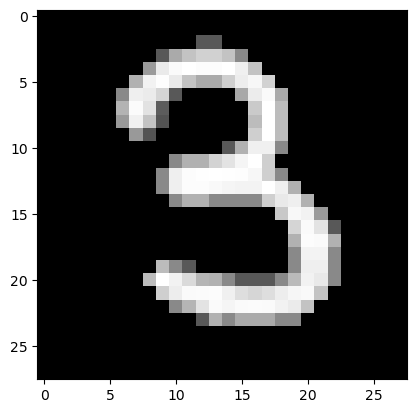

In [64]:
path = './data/test/3_Paint.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

# Преобразование
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
img = img.astype(np.float32)/255.0

img = torch.from_numpy(img)

In [65]:
predict = model(img)
print(F.softmax(predict, dim=1).detach().numpy().argmax())
F.softmax(predict, dim=1).detach().numpy()

3


array([[2.4008369e-07, 1.7684800e-06, 1.5075431e-04, 9.9967563e-01,
        9.4050670e-12, 1.4720437e-04, 7.0140624e-07, 1.1042116e-09,
        2.3768118e-05, 5.8025607e-10]], dtype=float32)

### Реальное фото

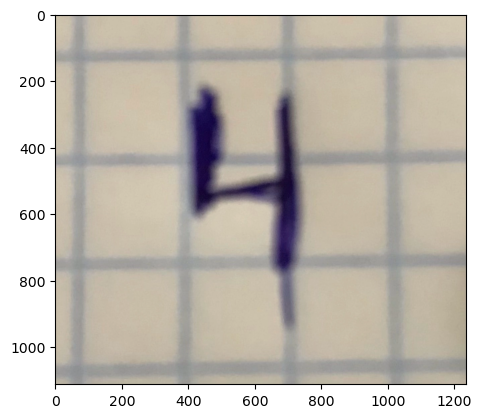

In [66]:
# Чтение
img = cv2.imread('./data/test/4_Real.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

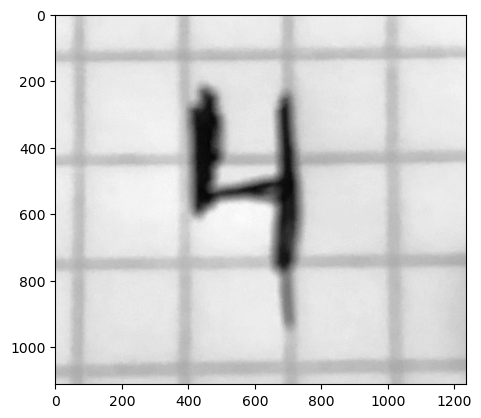

In [67]:
# Тона серого
gray_img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
plt.imshow(gray_img,cmap='gray')

In [68]:
# Увеличение контраста с помощью выравнивания гистограммы
# contrasted_img = cv2.equalizeHist(gray_img)
# plt.imshow(contrasted_img, cmap='gray')

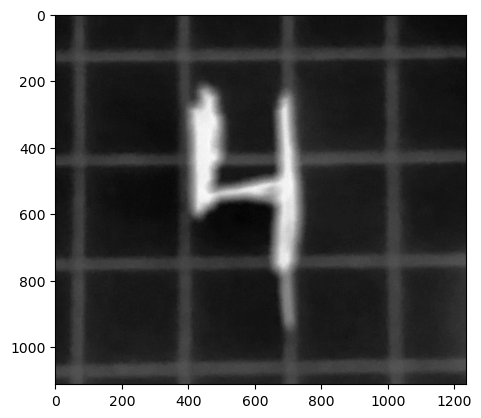

In [69]:
# Инверсия цветов
inverted_img = cv2.bitwise_not(gray_img)
plt.imshow(inverted_img, cmap='gray')

In [70]:
# Удаление шума с помощью морфологического закрытия
# kernel = np.ones((4, 4), np.uint8)
# cleared_img = cv2.morphologyEx(inverted_img, cv2.MORPH_CLOSE, kernel)
# plt.imshow(cleared_img, cmap='gray')
cleared_img = inverted_img

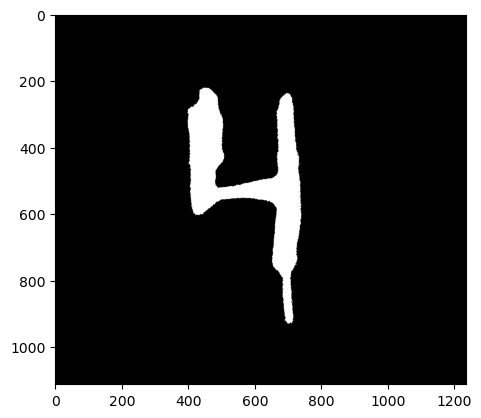

In [71]:
# Примените метод Оцу для бинаризации
_, binary_img = cv2.threshold(cleared_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary_img, cmap='gray')

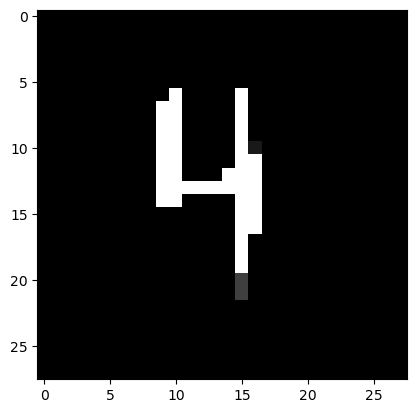

In [72]:
desired_size = (28, 28)
resized_img = cv2.resize(binary_img, desired_size, interpolation=cv2.INTER_CUBIC)
plt.imshow(resized_img, cmap='gray')

In [73]:
img = resized_img
# Преобразование
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
img = img.astype(np.float32)/255.0

img = torch.from_numpy(img)

predict = model(img)
print(F.softmax(predict, dim=1).detach().numpy().argmax())
F.softmax(predict, dim=1).detach().numpy()

4


array([[3.0263378e-05, 1.9556144e-03, 1.0690242e-04, 3.4115725e-04,
        7.2299045e-01, 1.9639267e-03, 2.7212687e-04, 1.2370896e-02,
        2.0736633e-03, 2.5789508e-01]], dtype=float32)

# Kaggle

In [81]:
# формирование таблицы для сайта kaggle с использованием нашей модели
import pandas as pd

data = pd.read_csv('./data/test.csv')
data_tensor = torch.tensor(data.values, dtype=torch.float32)

class CustomDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

batch_size = 64
test_dataset = CustomDataset(data_tensor)
test_ds_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

predicted_labels = []
for batch in tqdm(test_ds_loader):
    batch = batch.view(batch.size(0), 1, 28, 28)
    with torch.no_grad():
        predictions = model(batch)

    predicted_batch_labels = torch.argmax(predictions, dim=1)
    predicted_labels.extend(predicted_batch_labels.tolist())

image_ids = list(range(1, len(predicted_labels) + 1))
image_id_label_pairs = list(zip(image_ids, predicted_labels))


df = pd.DataFrame(image_id_label_pairs, columns=["ImageId", "Label"])
df.to_csv('./data/output.csv', index=False)
df

100%|██████████| 438/438 [00:00<00:00, 5091.08it/s]


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
